In [ ]:
%pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393

In [ ]:
import torch
if torch.cuda.is_bf16_supported():
    dtype = torch.bfloat16
else:
    dtype = torch.float16


In [ ]:
# Cell 1: Setup and imports
# needed as this function doesn't like it when the lm_head has its size changed
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

# Cell 2: Main imports and model loading
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

NUM_CLASSES = 2 # YTA, NTA only

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
# dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

model_name = "unsloth/Qwen3-4B-Base";load_in_4bit = False

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)
# Explicitly move the model to the CUDA device after loading
model.to("cuda")

# Cell 3: Trim classification head
number_token_ids = []
for i in range(0, NUM_CLASSES+1):
    number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
# keep only the number tokens from lm_head
par = torch.nn.Parameter(model.lm_head.weight[number_token_ids, :])

old_shape = model.lm_head.weight.shape
old_size = old_shape[0]
print(par.shape)
print(old_shape)

model.lm_head.weight = par

reverse_map = {value: idx for idx, value in enumerate(number_token_ids)}
reverse_map

# Cell 4: Setup PEFT model
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head", # can easily be trained because it now has a small size
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))



Major: 8, Minor: 0
==((====))==  Unsloth 2025.5.9: Fast Qwen3 patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([3, 2560])
torch.Size([151936, 2560])
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 33037824


In [ ]:
# Cell 5: Load and prepare dataset
kaggle = os.getcwd() == "/kaggle/working"
input_dir = "/kaggle/input/amitheasshole/" if kaggle else ""

# Load the AITA dataset
data = pd.read_csv(input_dir + "amitheasshole.csv", nrows = 10000)


In [ ]:
print(data.shape)
print(data.head(10))

(10000, 6)
                                               title post_id  over_18  \
0        AITA for cutting communications with my ex?  b3jk0h    False   
1  aita for thinking my girlfriend is dating me o...  b3jpqu    False   
2             AITA For looking at my partners phone?  b3jsz3    False   
3  AITA for taking an unvaccinated child to a fri...  b3k5l9    False   
4  AITA when I give up on trying to follow the ru...  b3kbde    False   
5       WIBTA for saying we should put down our dog?  b3kfm7    False   
6  WIBTA for starting a relationship with a girl ...  b3ko1i    False   
7       AITA for not wanting to give a wedding gift?  b3l0gb    False   
8  WIBTA if I tell an awkward coworker he’s comin...  b3lgi3    False   
9  WIBTA if I tell a guy I know his girlfriend is...  b3lube    False   

       subreddit  link_flair_text  \
0  AmItheAsshole  No A-holes here   
1  AmItheAsshole          Asshole   
2  AmItheAsshole   Not the A-hole   
3  AmItheAsshole          Asshole   


Label distribution:
link_flair_text
Not the A-hole    2302
Asshole            808
Name: count, dtype: int64
Before balancing:
link_flair_text
Not the A-hole    2302
Asshole            808
Name: count, dtype: int64
Balancing to 808 samples per class
After balancing:
link_flair_text
Asshole           808
Not the A-hole    808
Name: count, dtype: int64
Total samples: 1616
Training samples: 1454, Validation samples: 162


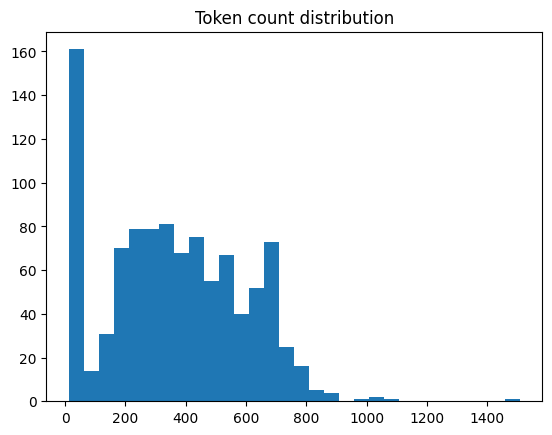

Unsloth: Tokenizing ["text"]:   0%|          | 0/1454 [00:00<?, ? examples/s]

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
38.43 GB of memory reserved.


In [ ]:

# Create label mapping for AITA verdicts - BINARY ONLY
label_mapping = {
    'Asshole': 1,      # You're the A-hole
    'Not the A-hole': 2,      # Not the A-hole
}

# Filter for posts with YTA or NTA labels only
valid_labels = set(label_mapping.keys())
data = data[data['link_flair_text'].isin(valid_labels)].copy()

# Combine title and self_text for the full post content
data['text'] = data['title'].fillna('') + '\n\n' + data['self_text'].fillna('')
data['label'] = data['link_flair_text'].map(label_mapping)

# Remove very short posts (less than 50 characters) and very long posts
data = data[(data['text'].str.len() > 50) & (data['text'].str.len() < 10000)]

# Sample if dataset is too large (optional)
if len(data) > 30000:
    data = data.sample(n=10000, random_state=42)

# Balance the dataset if needed (optional)
print("Label distribution:")
print(data['link_flair_text'].value_counts())


print("Before balancing:")
print(data['link_flair_text'].value_counts())

# ✅ BALANCE TO 50/50
yta_data = data[data['label'] == 1]
nta_data = data[data['label'] == 2]

# Use the smaller class size to balance
min_count = min(len(yta_data), len(nta_data))
print(f"Balancing to {min_count} samples per class")

yta_balanced = yta_data.sample(n=min_count, random_state=42)
nta_balanced = nta_data.sample(n=min_count, random_state=42)

# Combine and shuffle
data = pd.concat([yta_balanced, nta_balanced])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("After balancing:")
print(data['link_flair_text'].value_counts())
print(f"Total samples: {len(data)}")

# Continue with train/test split (this will maintain the 50/50 ratio)
# train_df, val_df = train_test_split(data, test_size=0.1, random_state=42,stratify=data['label'])
train_df, val_df = train_test_split(data[['text', 'label']], test_size=0.1, random_state=42, stratify=data['label'])
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Cell 6: Plot token distribution
token_counts = [len(tokenizer.encode(x)) for x in train_df.text.sample(min(1000, len(train_df)))]
plt.hist(token_counts, bins=30)
plt.title("Token count distribution")
plt.show()

# Cell 7: Setup prompt template and format data
prompt = """You are judging an AITA (Am I The Asshole) post from Reddit. Read the following post and determine if the person is the asshole or not.

Post:
{}

Classify this post into one of the following categories:
class 1: YTA (You're the A-hole) - The person writing the post is in the wrong
class 2: NTA (Not the A-hole) - The person writing the post is not in the wrong

SOLUTION
The correct answer is: class {}"""

def formatting_prompts_func(dataset_):
    texts = []
    for i in range(len(dataset_['text'])):
        text_ = dataset_['text'].iloc[i]
        label_ = dataset_['label'].iloc[i]

        text = prompt.format(text_, label_)
        texts.append(text)
    return texts

# apply formatting_prompts_func to train_df
train_df['text'] = formatting_prompts_func(train_df)
train_dataset = datasets.Dataset.from_pandas(train_df,preserve_index=False)
# Cell 8: Custom data collator
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        tokenizer, # Pass tokenizer to the collator
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        reverse_map: dict = None, # Pass reverse_map
        label_mapping: dict = None, # Pass original label_mapping
        prompt_template: str = None, # Pass the prompt template
        **kwargs,
    ):
        super().__init__(tokenizer, *args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index
        self.reverse_map = reverse_map
        self.label_mapping = label_mapping
        self.prompt_template = prompt_template
        self.tokenizer = tokenizer

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        # The base collator handles padding and creates input_ids, attention_mask, and labels
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Original full text before formatting
            # Access the original example to get the true label before formatting
            # This requires the original dataset structure to be available in examples,
            # which `from_pandas` does provide if preserve_index=False (which it is).
            # However, the example passed to collator is the output of formatting_prompts_func
            # Let's assume the formatted text still implicitly contains the label information
            # Or, we can rely on the labels generated by the base collator IF the label tokens are present

            # We need to find the token ID for the specific label digit at the end of the prompt.
            # The prompt ends with "class {label_digit}" where label_digit is '1' or '2'.
            # We need the token ID for '1' and '2'. We already computed these.
            label_token_ids = self.reverse_map.keys() # These are the tokens for '0', '1', '2'

            labels = batch["labels"][i]
            attention_mask = batch["attention_mask"][i]

            # Find the end of the non-padded sequence
            # last_non_padding_idx = (attention_mask.bool()).nonzero()[-1].item()

            # Instead of relying on the last non-padding token,
            # find the token ID corresponding to the label digit ("1" or "2")
            # which should be near the end of the sequence.
            # This is safer because the last token might not be the digit itself.
            # We know the prompt ends with "class 1" or "class 2".
            # Let's try to find the token for '1' or '2' near the end.

            # Convert sequence to list for easier searching
            label_sequence = labels.tolist()

            found_label_token_idx = -1
            true_label_digit = -1 # The actual digit '1' or '2'

            # Iterate backwards from the end of the non-padded sequence
            # to find the first occurrence of a label token ('1' or '2')
            last_non_padding_idx = (attention_mask.bool()).sum().item() - 1

            # Define the tokens for '1' and '2' dynamically from reverse_map
            token_id_for_1 = None
            token_id_for_2 = None
            for original_token_id, new_index in self.reverse_map.items():
                 # We need to know which original token corresponds to which digit
                 # Let's re-encode the digits to be sure
                 encoded_1 = self.tokenizer.encode("1", add_special_tokens=False)[0]
                 encoded_2 = self.tokenizer.encode("2", add_special_tokens=False)[0]
                 if original_token_id == encoded_1:
                     token_id_for_1 = original_token_id
                 if original_token_id == encoded_2:
                     token_id_for_2 = original_token_id

            # Search near the end for the specific label token ID (1 or 2)
            # We search backwards from the last non-padding token
            # Search within the last 10 tokens as a heuristic
            search_start_idx = max(0, last_non_padding_idx - 10) # Look in the last 10 non-padding tokens

            for idx in range(last_non_padding_idx, search_start_idx - 1, -1):
                current_token_id = label_sequence[idx]
                if current_token_id in [token_id_for_1, token_id_for_2]:
                    found_label_token_idx = idx
                    # We found the token id for the digit 1 or 2
                    # This is the token we want to predict
                    batch["labels"][i, :found_label_token_idx] = self.ignore_index
                    # Keep only the label for the found token
                    batch["labels"][i, found_label_token_idx + 1:] = self.ignore_index

                    # Map the original token ID to the new lm_head index (0, 1, or 2)
                    # Ensure the found_label_token_idx corresponds to a token we care about predicting ('1' or '2')
                    if current_token_id in self.reverse_map:
                        batch["labels"][i, found_label_token_idx] = self.reverse_map[current_token_id]
                    else:
                         # This case should ideally not happen if the logic is correct,
                         # but as a fallback, ignore this token if it's not in the map
                         batch["labels"][i, found_label_token_idx] = self.ignore_index

                    break # Stop searching once the label token is found

            # If the label token ('1' or '2') was not found near the end,
            # this sample is problematic. We should set all labels to ignore_index.
            if found_label_token_idx == -1:
                print(f"Warning: Could not find label token (1 or 2) near the end of sequence {i}.")
                # Optionally set all labels to ignore_index for this problematic sample
                batch["labels"][i, :] = self.ignore_index


        return batch

# Update the collator initialization to pass necessary arguments
collator = DataCollatorForLastTokenLM(
    tokenizer=tokenizer,
    reverse_map=reverse_map,
    label_mapping=label_mapping, # Pass label_mapping if needed, though reverse_map should be sufficient
    prompt_template=prompt # Pass prompt template if needed for debugging/more complex logic
)

# Cell 9: Setup trainer (rest of the code remains the same)
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, # not needed because group_by_length is True
    args = TrainingArguments(
        per_device_train_batch_size = 16,  # Adjust based on your GPU
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = (dtype == torch.float16),
        bf16 = (dtype == torch.bfloat16),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 3,
        report_to = "none",
        group_by_length = True,
        # max_steps=120,
    ),
    data_collator=collator,
    dataset_text_field="text",
)

    # args = TrainingArguments(
    #     per_device_train_batch_size = 32,
    #     gradient_accumulation_steps = 1,
    #     warmup_steps = 10,
    #     learning_rate = 1e-4,
    #     fp16 = not torch.cuda.is_bf16_supported(),
    #     bf16 = torch.cuda.is_bf16_supported(),
    #     logging_steps = 1,
    #     optim = "adamw_8bit",
    #     weight_decay = 0.01,
    #     lr_scheduler_type = "cosine",
    #     seed = 3407,
    #     output_dir = "outputs",
    #     num_train_epochs = 1,
    #     # report_to = "wandb",
    #     report_to = "none",
    #     group_by_length = True,
    # ),

# Cell 10: Show memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")


In [ ]:

# Cell 11: Train the model
trainer_stats = trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,454 | Num Epochs = 3 | Total steps = 273
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 33,037,824/4,055,513,600 (0.81% trained)


Step,Training Loss
1,0.751200
2,0.693100
3,0.620900
4,0.625900
5,0.723900
6,0.545600
7,0.609900
8,0.761000
9,0.773000
10,0.810500


In [ ]:

# Cell 12: Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

# Cell 13: Enable inference mode
FastLanguageModel.for_inference(model)
print()

# Cell 14: Remake the old lm_head
# Save the current (trimmed) lm_head and bias
trimmed_lm_head = model.lm_head.weight.data.clone()
trimmed_lm_head_bias = model.lm_head.bias.data.clone() if hasattr(model.lm_head, "bias") and model.lm_head.bias is not None else torch.zeros(len(number_token_ids), device=trimmed_lm_head.device)

# Create a new lm_head with shape [old_size, hidden_dim]
hidden_dim = trimmed_lm_head.shape[1]
new_lm_head = torch.full((old_size, hidden_dim), 0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device)
new_lm_head_bias = torch.full((old_size,), -1000.0, dtype=trimmed_lm_head_bias.dtype, device=trimmed_lm_head_bias.device)

# Fill in the weights and bias for the allowed tokens (number_token_ids)
for new_idx, orig_token_id in enumerate(number_token_ids):
    new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]
    new_lm_head_bias[orig_token_id] = trimmed_lm_head_bias[new_idx]

# Update the model's lm_head weight and bias
with torch.no_grad():
    new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=True, device=model.device)
    new_lm_head_module.weight.data.copy_(new_lm_head)
    new_lm_head_module.bias.data.copy_(new_lm_head_bias)
    model.lm_head.modules_to_save["default"] = new_lm_head_module

print(f"Remade lm_head: shape = {model.lm_head.weight.shape}. Allowed tokens: {number_token_ids}")

# Cell 15: Batched inference on validation set
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

# Prepare inference prompt
inference_prompt_template = prompt.split("class {}")[0] + "class "

# Sort validation set by length for efficient batching
val_df['token_length'] = val_df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
val_df_sorted = val_df.sort_values(by='token_length').reset_index(drop=True)

display = 20
batch_size = 8  # Adjust based on your GPU
device = model.device
correct = 0
results = []

label_names = {1: 'YTA', 2: 'NTA'}

# Calculate confusion matrix
confusion_matrix = {'YTA_as_YTA': 0, 'YTA_as_NTA': 0, 'NTA_as_YTA': 0, 'NTA_as_NTA': 0}

with torch.inference_mode():
    for i in tqdm(range(0, len(val_df_sorted), batch_size), desc="Evaluating"):
        batch = val_df_sorted.iloc[i:i+batch_size]
        prompts = [inference_prompt_template.format(text) for text in batch['text']]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length).to(device)
        logits = model(**inputs).logits
        last_idxs = inputs.attention_mask.sum(1) - 1
        last_logits = logits[torch.arange(len(batch)), last_idxs, :]
        probs_all = F.softmax(last_logits, dim=-1)
        probs = probs_all[:, number_token_ids]
        preds = torch.argmax(probs, dim=-1).cpu().numpy()

        true_labels = batch['label'].tolist()
        correct += sum([p == t for p, t in zip(preds, true_labels)])

        # Update confusion matrix
        for p, t in zip(preds, true_labels):
            if t == 1 and p == 1:
                confusion_matrix['YTA_as_YTA'] += 1
            elif t == 1 and p == 2:
                confusion_matrix['YTA_as_NTA'] += 1
            elif t == 2 and p == 1:
                confusion_matrix['NTA_as_YTA'] += 1
            elif t == 2 and p == 2:
                confusion_matrix['NTA_as_NTA'] += 1

        for j in range(len(batch)):
            results.append({
                "text": batch['text'].iloc[j][:200],
                "true": true_labels[j],
                "pred": preds[j],
                "probs": probs[j][1:].float().cpu().numpy(),
                "ok": preds[j] == true_labels[j]
            })

accuracy = 100 * correct / len(val_df_sorted)
print(f"\nValidation accuracy: {accuracy:.2f}% ({correct}/{len(val_df_sorted)})")

# Print confusion matrix
print("\n--- Confusion Matrix ---")
print(f"YTA predicted as YTA: {confusion_matrix['YTA_as_YTA']}")
print(f"YTA predicted as NTA: {confusion_matrix['YTA_as_NTA']}")
print(f"NTA predicted as YTA: {confusion_matrix['NTA_as_YTA']}")
print(f"NTA predicted as NTA: {confusion_matrix['NTA_as_NTA']}")

print("\n--- Random samples ---")
for s in random.sample(results, min(display, len(results))):
    print(f"\nText: {s['text']}...")
    print(f"True: {label_names[s['true']]}  Pred: {label_names[s['pred']]} {'✅' if s['ok'] else '❌'}")
    print(f"Confidence: YTA: {s['probs'][0]:.3f}, NTA: {s['probs'][1]:.3f}")

# Clean up
if 'token_length' in val_df:
    del val_df['token_length']

# Cell 17: Test on custom examples (optional)
test_examples = [
    "I told my pregnant sister that she can't bring her emotional support peacock to my wedding. She says I'm being unreasonable and that the peacock helps with her anxiety. Now she's threatening not to come to the wedding at all.",
    "My neighbor's dog keeps pooping in my yard. After asking them multiple times to control their pet, I started collecting the poop and leaving it on their doorstep. They called me childish and petty.",
    "I ate my roommate's leftover pizza that had been in the fridge for a week. They got really mad even though it was starting to smell bad. I thought I was doing them a favor.",
]

print("\n--- Testing on custom examples ---")
for example in test_examples:
    prompt_text = inference_prompt_template.format(example)
    inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=max_seq_length).to(device)
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=1, do_sample=False)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    prediction = response.split("class ")[-1].strip()
    print(f"\nPost: {example[:150]}...")
    print(f"Prediction: {label_names.get(int(prediction), 'Unknown')}")

480.4391 seconds used for training.
8.01 minutes used for training.
Peak reserved memory = 38.43 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 97.151 %.
Peak reserved memory for training % of max memory = 0.0 %.

Remade lm_head: shape = torch.Size([151936, 2560]). Allowed tokens: [15, 16, 17]


Evaluating: 100%|██████████| 21/21 [00:05<00:00,  3.95it/s]



Validation accuracy: 53.70% (87/162)

--- Confusion Matrix ---
YTA predicted as YTA: 72
YTA predicted as NTA: 9
NTA predicted as YTA: 66
NTA predicted as NTA: 15

--- Random samples ---

Text: AITA for telling my gf that I need to study for my ACT?

[deleted]...
True: NTA  Pred: YTA ❌
Confidence: YTA: 0.905, NTA: 0.095

Text: AITA if I don't want to pool baby shower gifts with my mum?

Hello reddit, just need a quick opinion to help me to decide whether I'm valid in what I'm feeling or whether I'm just being a prick.  My f...
True: NTA  Pred: YTA ❌
Confidence: YTA: 0.679, NTA: 0.321

Text: AITA for stopping people from re-sharing the same story with me for the x'th time?

Basically the title, I have some friends who have a habit of repeating the same story to me multiple times. I unders...
True: NTA  Pred: YTA ❌
Confidence: YTA: 0.753, NTA: 0.244

Text: AITA Mac and Cheese

So I’m a 16(M) on a band trip to San Antonio, we stop to eat at Panera bread, me being me, I make a joke while i